# 0.0 IMPORTS 

In [66]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime


from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec 
from scipy                 import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr =max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 )))  


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] =24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()





## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
261227,645,5,2014-12-05,13218,1454,1,1,0,0,a,a,90.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [5]:
# fazer uma cópia do dataset quando muda de seção, somente para manter os dados , caso seja necessário recomeçar
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x)
cols_new = list( map(snakecase, cols_old))

#rename
df1.columns = cols_new


## 1.2. Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))



Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Ckeck NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
#competition_distance              2642
#df1['competition_distance'].max()  # Verificando qual a maior distancia de um concorrente  -> 75860.0
# SOLUÇÃO - > Vou aplicar uma distancia maxima = 200000.0 para os registros NAN desta coluna

#                                                                         200000.0 if math.isnan( df1['competition_distance']) else df1['competition_distance']
#                                                         apply(lambda x: 200000.0 if math.isnan(x   ['competition_distance']) else x  ['competition_distance'])
#                             df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)                            else x)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#===============================================================================================================
#competition_open_since_month    323348
# mes que o concorrente mais proximo foi aberto
# Pq este campo esta vazio? a loja ja estava aberta quando instalou a nossa loja ou ninguem resgistrou esta informação
# SOLUÇÃO - > APLICAR A DATA (mes) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO

#                                                       df1['date'].month if math.isnan( df1['competition_open_since_month']) else df1['competition_open_since_month']
#                                               lambda x: x['date'].month if math.isnan( x  ['competition_open_since_month']) else x  ['competition_open_since_month']
#                                     df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#===============================================================================================================
#competition_open_since_year     323348
# mes que o concorrente mais proximo foi aberto
# Pq este campo esta vazio? a loja ja estava aberta quando instalou a nossa loja ou ninguem resgistrou esta informação
# SOLUÇÃO - > APLICAR A DATA (ano) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


#===============================================================================================================
#promo2_since_week               508031
# SOLUÇÃO - > APLICAR A DATA (semana) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#===============================================================================================================
#promo2_since_year               508031
# SOLUÇÃO - > APLICAR A DATA (ano) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#===============================================================================================================
#promo_interval                  508031
#criando um mapa de mês
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Colocando 0 nos registros que possui a coluna promo_interval = 0
df1['promo_interval'].fillna(0, inplace=True)

# Criei uma coluna month_map onde será gravado o mes da coluna 'date' do registro, já convertido de acordo com a biblioteca criada
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Criei uma nova coluna que vai registrar 1 para quem tem promoção no mes de venda e 0 data de venda fora da promoçao
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['promo_interval'].split( ',') else 0, axis=1)

#===============================================================================================================

## 1.6. Change types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [14]:
# Criando dataframes de acordo com o typo da coluna
num_attributes = df1.select_dtypes( include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])


## 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() -x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
#Rename columns
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m





,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\leandro.figueira\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

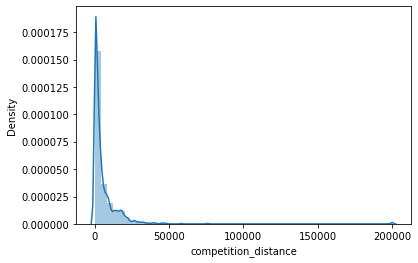

In [16]:
sns.distplot( df1['competition_distance'] )

## 1.7.2 Caterigal Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

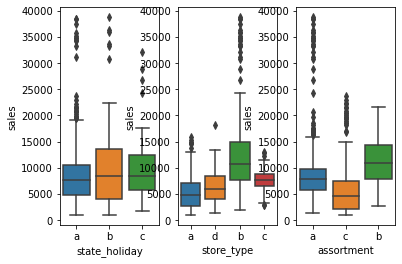

In [18]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )



# 2.0. PASSO 02 - FEATURE ENGINEETING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

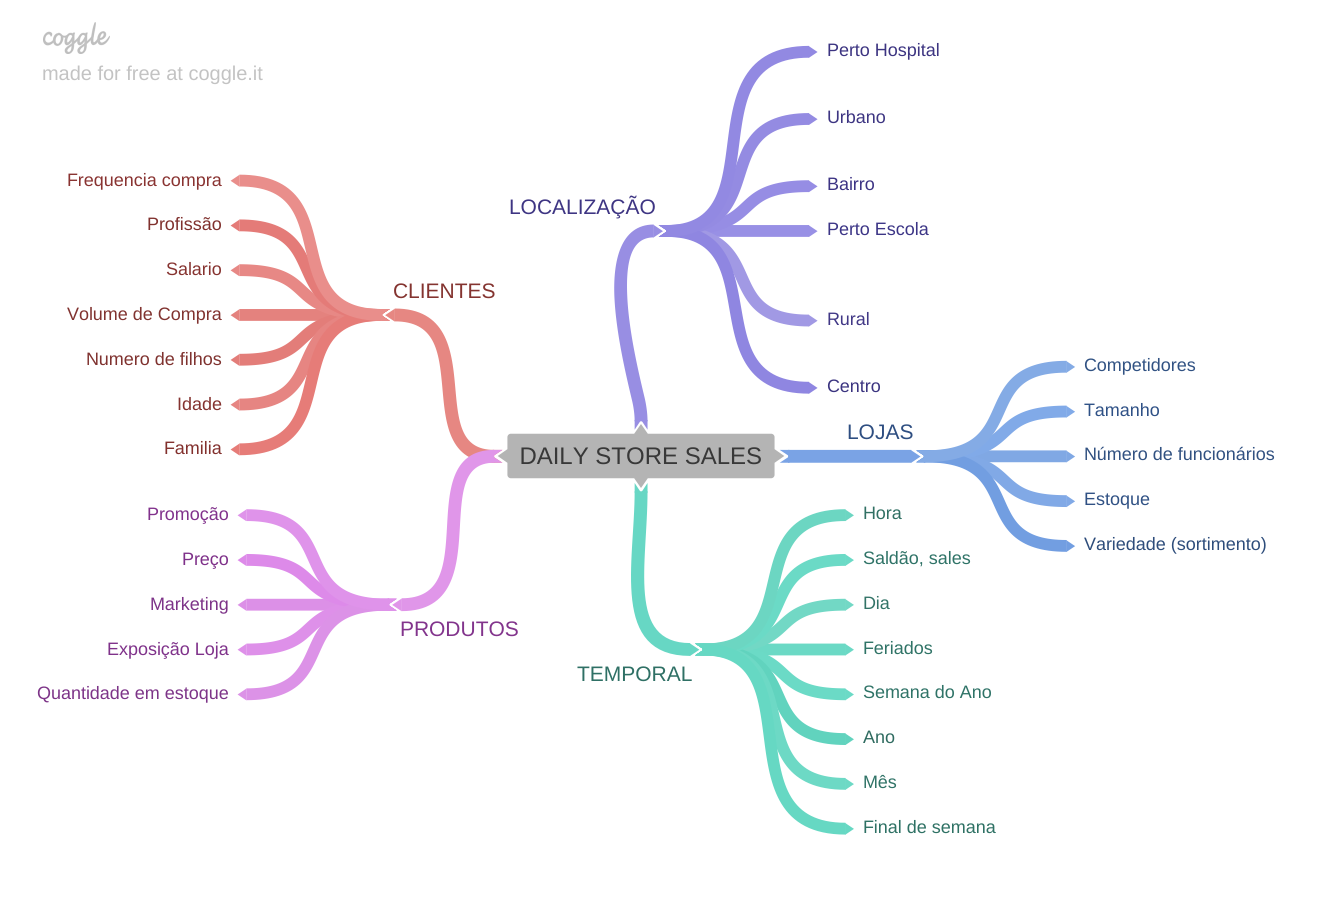

In [20]:
Image('img/DAILY_STORE_SALES.png')

## 2.1. Criação das Hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (desconto maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao lojgo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao lojgo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Feature Engineering

In [21]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
#df2['week_of_year'] = df2['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [22]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30 ).apply(lambda x: x.days).astype(int)



In [23]:
# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days).astype(int)


In [24]:
# ASSORTMENT
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [25]:
# State holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS (EDA)

In [31]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

C:\Users\leandro.figueira\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

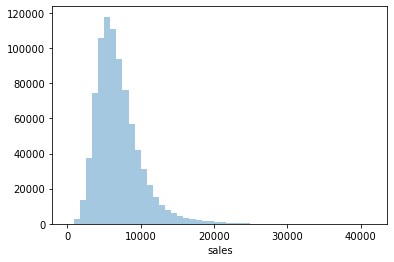

In [32]:
#plt.figure( figsize=(220,112))
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

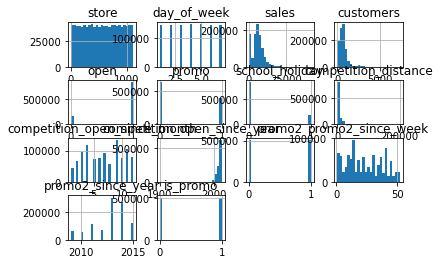

In [33]:
#plt.figure( figsize=(220,112))
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [35]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\leandro.figueira\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\leandro.figueira\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\leandro.figueira\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

<AxesSubplot:xlabel='sales', ylabel='Density'>

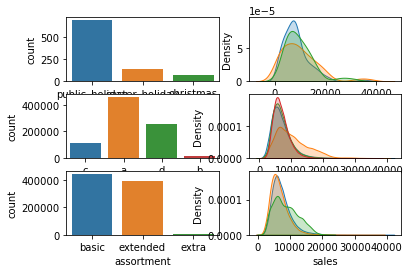

In [37]:
# state_holiday
#criando um grafico com todos os feriados
#plt.figure( figsize=(300,250))

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'])

#Criando um grafico com as colunas sobrepostas -> shade=True
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#==========================================================================================================

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#==========================================================================================================

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Analise Bivariada

## H1.  Lojas com maior sortimentos deveriam vender mais.
***FALSA***  Lojas cim MAIOR SORTIMENTO vendem MENOS

<AxesSubplot:xlabel='year_week'>

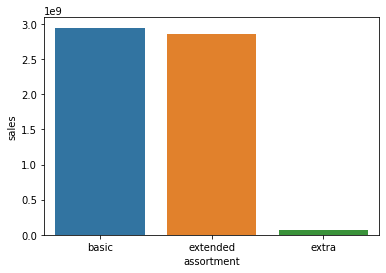

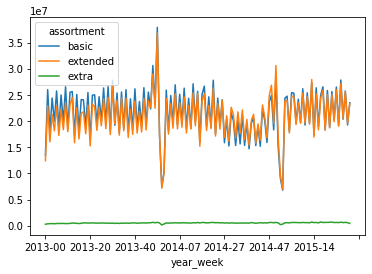

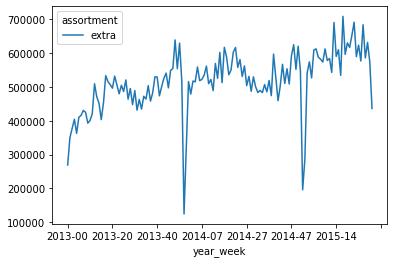

In [38]:
#sortimento + vendas --> agrupa por sortimento
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

#semana do ano + sortimento + vendas  --> agrupa por semana di ano + sortimento
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

# verificando somente o sortimento extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()


## **H2.** Lojas com competidores mais próximos deveriam vender menos.
***Falsa*** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

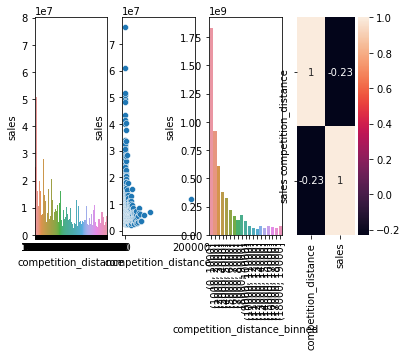

In [39]:
#sortimento + vendas --> agrupa por sortimento

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,4,1)
sns.barplot(x='competition_distance', y='sales', data=aux1);


aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,4,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);


plt.subplot(1,4,3)
#criando uma lista para agrupar as distancias
# vai de 0 a 20000 e com 1000(grupos) agrupamentos
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);


plt.subplot(1,4,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);




## **H3.** Lojas com competidores a mais tempo deveriam vender mais.
***Falsa*** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS


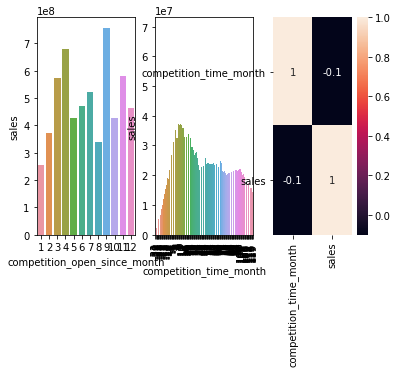

In [40]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()
sns.barplot( x='competition_open_since_month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
aux2 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux3 = aux2[( aux2['competition_time_month'] < 120) & (aux2['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux3);
plt.xticks( rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap( aux2.corr(method='pearson'), annot=True);


## **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***Falsa***  Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção


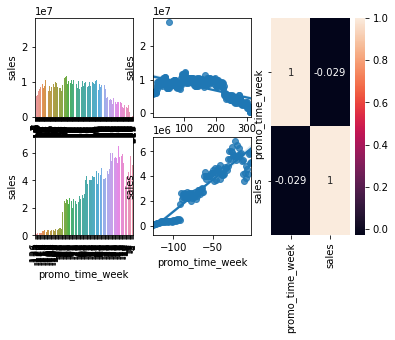

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ]  # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);


## **H5.** Lojas com mais dias de promoção deveriam vender mais.

***Validar*** no proximo ciclo crisp

## **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
***Falsa***  Lojas com ais promoções consecutivas vendem menos

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


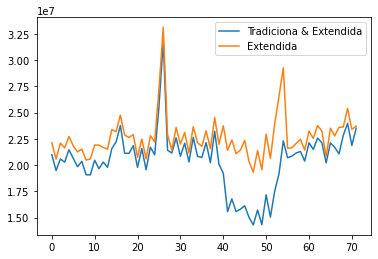

In [43]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradiciona & Extendida', 'Extendida']);






# **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
***Falsa*** Lojas abertas durante o feriado do Natal vendem menos


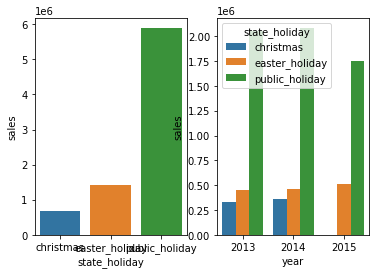

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);



# **H8.** Lojas deveriam vender mais ao lojgo dos anos.
***Falsa***  Lojas vendem menos ao longo dos anos

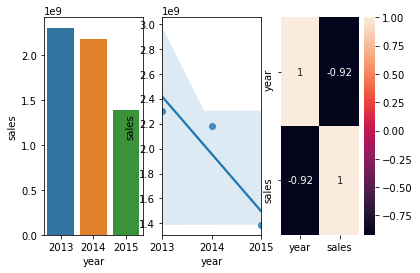

In [45]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


# **H9.** Lojas deveriam vender mais no segundo semestre do ano.
***Falsa***  Lojasvendem menos no segundo semestre do ano



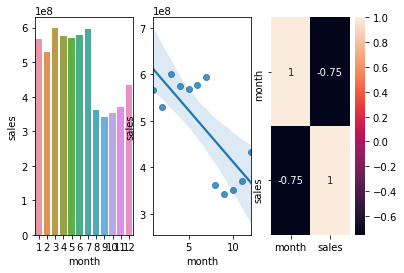

In [46]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mes

In [47]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux1.head(15)

KeyError: 'day'

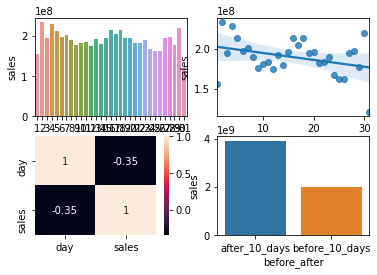

In [48]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);



# **H11.** Lojas deveriam vender menos aos finais de semana.
***Verdadeira*** Lojas vendem menos no final de semana


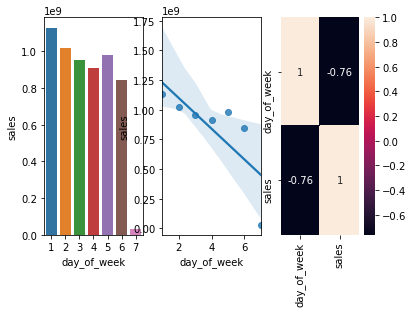

In [49]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# **H12.** Lojas deveriam vender menos durante os feriados escolares
***Verddeiro*** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e agosto

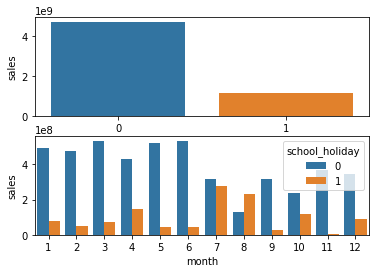

In [50]:
aux1 =df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);


aux2 =df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

In [51]:
from tabulate import tabulate

In [52]:
tab =[ ['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Media'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
     ]
print( tabulate(tab, headers='firstrow'))






Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Media
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [53]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


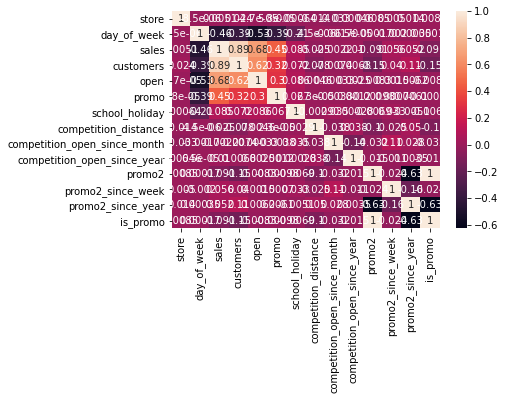

In [54]:
correlation =num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

In [55]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [56]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [57]:
pd.crosstab( a['state_holiday'], a['store_type'])  #.as_matrix()

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [58]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#Final dataset
d = pd.Dataframe( {'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )



AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [59]:
sns.heatmap(d, annot=True )

NameError: name 'd' is not defined

# 5.0. PASSO 04 - PREPARAÇÃO DOS DADOS -  DATA PREPARATION

In [60]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [61]:
a =df5.select_dtypes( include=['int64', 'int32', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


C:\Users\leandro.figueira\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

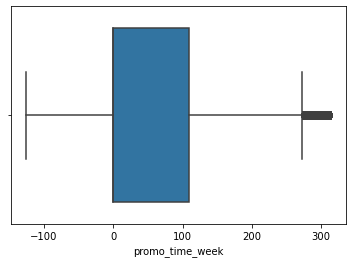

In [62]:
# verificando colunas com outliers
#sns.boxplot( df5['competition_distance'])
#sns.boxplot( df5['competition_time_month'])
sns.boxplot( df5['promo_time_week'])
#sns.boxplot( df5['year'])

In [63]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform( df5[['year']].values)

C:\Users\leandro.figueira\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

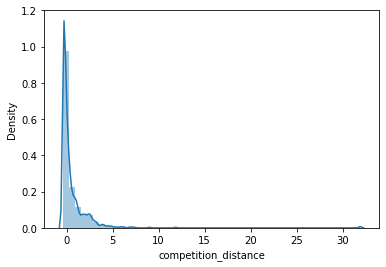

In [64]:
# verificando colunas depois de fazer o rescaling
sns.distplot( df5['competition_distance'])
#sns.distplot( df5['competition_time_month'])
#sns.distplot( df5['promo_time_week'])
#sns.distplot( df5['year'])

## 5.3. Transformação

### 5.3.1. Encoding

In [65]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [70]:
#state_holiday - One Hot Encoding  - cria uma coluna para cada tipo de feriado colocando 0 ou 1
#df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [72]:
# store_type - Label Encoding - coloca um numero sequencial para cada valor dentro da coluna
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [74]:
#assortment - Ordinal Encoding - eu defino o numero para cada valor dentro da coluna
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

In [75]:
df5['sales'] = np.loglp( df5['sales'] )
sns.distplot( df5['sales'])

AttributeError: module 'numpy' has no attribute 'loglp'

### 5.3.3. Nature Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * ( 2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * ( 2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * ( 2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * ( 2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52) ) )

df5.head()